To run this yourself, before running the jupyter notebook, openup postgres in command line & make tables test1 and test2, as well as run CREATE EXTENSION btree_gist; 

In [59]:
import psycopg2
import random
import timeit
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [6]:
conn = psycopg2.connect("dbname=postgres user=postgres host = /var/run/postgresql/")
cur = conn.cursor()

In [7]:
def c_setup_1(N):
    random.seed(42)
    cur.execute('DROP TABLE test1;')
    cur.execute('CREATE TABLE test1 (coverage int8range);')
    for i in range(N):
        a = random.randint(0, 2**32)
        b = random.randint(0, 2**32)
        if a < b:
            (lower, upper) = (a, b) 
        else:
            (upper, lower) = (a, b)
        cur.execute(f'INSERT INTO test1 VALUES (int8range({lower}, {upper}));')
    cur.execute('CREATE INDEX test1_i ON test1 USING GIST (coverage);')

In [100]:
N_list = np.arange(0, 101000, 1000)
t_list = []
for N in N_list:
    if N%10000==0: print(N)
    c_setup_1(N)
    t_list.append(timeit.timeit(lambda: cur.execute('SELECT range_agg(coverage) FROM test1;'), number=1))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000


Text(0.5, 1.0, 'range_agg big O')

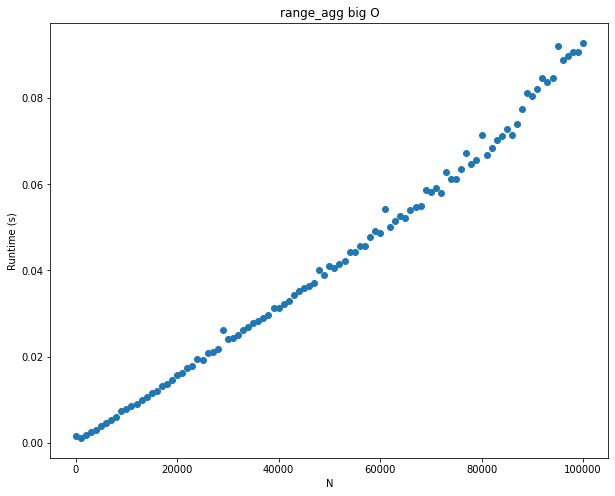

In [103]:
fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(N_list, t_list)
ax.set_xlabel('N')
ax.set_ylabel('Runtime (s)')
ax.set_title('range_agg big O')
#Outliers probably because I was running gwemopt stuff concurrently

In [8]:
def c_setup_2(M):
    random.seed(14)
    cur.execute('DROP TABLE test2;')
    cur.execute('CREATE TABLE test2 (row1 int8, row2 int8range);')
    for i in range(M):
        c = random.randint(0, 2**32)
        d = random.randint(0, 2**32)
        e = random.randint(0, 2**32)
        if d < e:
            (lower, upper) = (d, e) 
        else:
            (upper, lower) = (d, e)
        cur.execute(f'INSERT INTO test2 (row1, row2) VALUES ({c}, int8range({lower}, {upper}));')
    cur.execute('CREATE INDEX test2_i1 ON test2 USING GIST (row1);')
    cur.execute('CREATE INDEX test2_i2 ON test2 USING GIST (row2);')

In [54]:
N_list = [50000]
M_list = np.arange(1000, 301000, 1000)
sum_list = []
t_list_1 = []
t_list_2 = []
for N in N_list:
    print('N: ', N)
    c_setup_1(N)
    for M in M_list:
        print('M: ', M)
        c_setup_2(M)
        t_list_1.append(timeit.timeit(lambda: cur.execute('SELECT row1 FROM test2 where test2.row1 <@ (SELECT range_agg(coverage) FROM test1);'), number=1))
        t_list_2.append(timeit.timeit(lambda: cur.execute('SELECT row2 FROM test2 where test2.row2 && (SELECT range_agg(coverage) FROM test1);'), number=1))
        sum_list.append(N+M)

N:  50000
M:  1000
M:  2000
M:  3000
M:  4000
M:  5000
M:  6000
M:  7000
M:  8000
M:  9000
M:  10000
M:  11000
M:  12000
M:  13000
M:  14000
M:  15000
M:  16000
M:  17000
M:  18000
M:  19000
M:  20000
M:  21000
M:  22000
M:  23000
M:  24000
M:  25000
M:  26000
M:  27000
M:  28000
M:  29000
M:  30000
M:  31000
M:  32000
M:  33000
M:  34000
M:  35000
M:  36000
M:  37000
M:  38000
M:  39000
M:  40000
M:  41000
M:  42000
M:  43000
M:  44000
M:  45000
M:  46000
M:  47000
M:  48000
M:  49000
M:  50000
M:  51000
M:  52000
M:  53000
M:  54000
M:  55000
M:  56000
M:  57000
M:  58000
M:  59000
M:  60000
M:  61000
M:  62000
M:  63000
M:  64000
M:  65000
M:  66000
M:  67000
M:  68000
M:  69000
M:  70000
M:  71000
M:  72000
M:  73000
M:  74000
M:  75000
M:  76000
M:  77000
M:  78000
M:  79000
M:  80000
M:  81000
M:  82000
M:  83000
M:  84000
M:  85000
M:  86000
M:  87000
M:  88000
M:  89000
M:  90000
M:  91000
M:  92000
M:  93000
M:  94000
M:  95000
M:  96000
M:  97000
M:  98000
M:  99000
M:  10000

Text(0, 0.5, 'Runtime (s)')

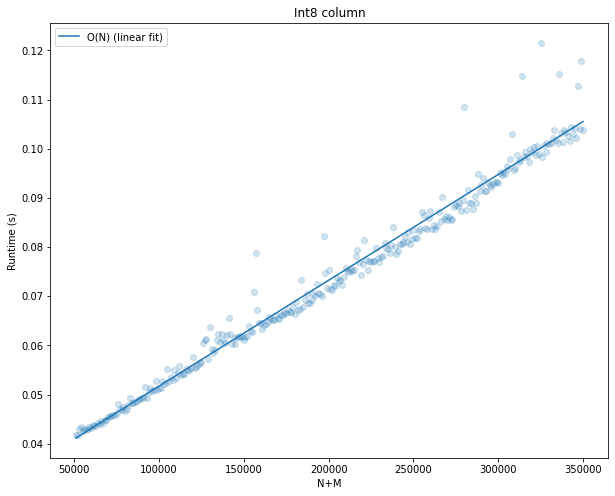

In [99]:
fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(sum_list, t_list_1, alpha = 0.2)
ax.plot(sum_list, 2.15346613e-07*np.asarray(sum_list)+3.01658852e-02, label = 'O(N) (linear fit)')
#ax.plot(sum_list, 1.13580084e-08*np.asarray(sum_list)*np.log2(np.asarray(sum_list))+3.29053034e-02, label = 'O(NLogN)')
ax.set_title('Int8 column')
ax.legend()
ax.set_xlabel('N+M')
ax.set_ylabel('Runtime (s)')

In [82]:
curve_fit(O_N, sum_list, t_list_1), curve_fit(O_N_Log_N, sum_list, t_list_1)

((array([2.15346613e-07, 3.01658852e-02]),
  array([[ 3.78636211e-18, -7.59165607e-13],
         [-7.59165607e-13,  1.80610106e-07]])),
 (array([1.13580084e-08, 3.29053034e-02]),
  array([[ 1.02828481e-20, -3.66097166e-14],
         [-3.66097166e-14,  1.58079211e-07]])))

Text(0.5, 1.0, 'int8range column')

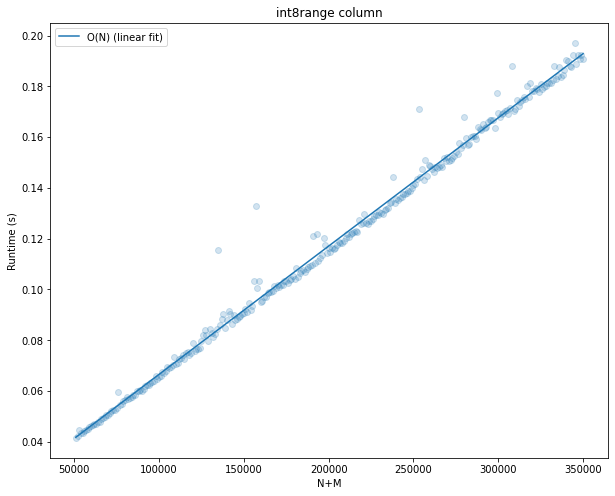

In [98]:
fig, ax = plt.subplots(figsize = (10,8))
ax.scatter(sum_list, t_list_2, alpha = 0.2)
ax.plot(sum_list, np.asarray(sum_list)*5.05515330e-07+1.59767485e-02, label = 'O(N) (linear fit)')
#ax.plot(sum_list, np.asarray(sum_list)*np.log2(np.asarray(sum_list))*2.66521134e-08+2.24438493e-02, label = 'O(NLogN)') #'Slope' on this is so small that it's essentiall linear
ax.legend()
ax.set_xlabel('N+M')
ax.set_ylabel('Runtime (s)')
ax.set_title('int8range column')

In [84]:
curve_fit(O_N, sum_list, t_list_2), curve_fit(O_N_Log_N, sum_list, t_list_2)

((array([5.05515330e-07, 1.59767485e-02]),
  array([[ 7.26662924e-18, -1.45695915e-12],
         [-1.45695915e-12,  3.46619413e-07]])),
 (array([2.66521134e-08, 2.24438493e-02]),
  array([[ 2.06893882e-20, -7.36598100e-14],
         [-7.36598100e-14,  3.18059949e-07]])))

In [57]:
def O_N(x, m, b):
    return m*x+b

In [83]:
def O_N_Log_N(x, m, b):
    return m*x*np.log2(x)+b

In [73]:
np.log2(2)

1.0